In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
def get_data(tickers, start_date, end_date, columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']):
    """
    Obs:
    The function gets the Adjusted Close price for the tickers within the dates informed
    
    Input: 
    
    tickers: list of tickers to get
    start_data: data format like "aaaa-mm-dd". Necessary use a valid trade day
    end_data: data format like "aaaa-mm-dd". Necessary use a valid trade day
    columns: desired columns to get from yfinance (Open, High, Low, Close, Volume)

    Output:
    dataframe with the adjusted close price for the tickers and dates informed. 
    
    """
    
    #
    
        
    df = yf.download(tickers, start=start_date, end=end_date)[columns]
   
    return df



def norm(df, start, end):
    df = df.loc[start:end]
    norm_df = df / df.iloc[0,:]
    return norm_df




def rolling_mean(df, window):
    """
    Obs:
    The function gets the simple moving average for each ticker
    
    Input: 
    
    df: dataframe with stock prices
    tickers: list of tickers

    Output:
    dataframe the simple moving average for each ticker
    
    """    
    sma = df.rolling(window=window).mean()
    return sma 



def rolling_std(df, window):
    """
    Obs:
    The function gets the simple moving average for each ticker
    
    Input: 
    
    df: dataframe with stock prices
    tickers: list of tickers
    window: number of days to compose the interval

    Output:
    dataframe the simple moving average for each ticker
    
    """    
    moving_std = df.rolling(window=window).std()
    return moving_std



def bollinger_bands(df, window, number_of_std):
    
    """
    Obs:
    The function returns the Bollinger Bands based on df, ticker, window and number of standard deviation
    
    Input: 
    
    df: dataframe with stock prices
    tickers: list of tickers
    window: number of days to compose the interval
    number_of_std: number of the std for calculate the bollinger bands

    Output:
    sma : simple moving average
    upper_band
    lower_band
    
    """  
    sma = rolling_mean(df, window)
    moving_std = rolling_std(df, window)
    upper_band = sma + moving_std * number_of_std
    lower_band = sma - moving_std * number_of_std
    return sma, upper_band, lower_band



def daily_return(df, periods_to_shift):
    
    """
    Obs:
    The function returns the stock's returns based on the period informed
    
    Input: 
    
    df: dataframe with stock prices
    periods_to_shift: Periods to shift for forming percent change.
    
    Output:
    dataframe with returns based on the period informed
    
    """  
    
    df = df.pct_change(periods = periods_to_shift)
    # check the type of object to do the correct change in the first row 
    if isinstance(df, pd.Series) != True:
        df.iloc[0,:] = 0
    else:
        df[0] = 0
    return df




# ============================================= Plot Functions =================================

def plot_data(df, title, x_label, y_label):
    df.plot(figsize=(15,8))  
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.axhline(y=1)
    plt.show()



def plot_line(stock):
    """
    Only for individual stocks
    """
    
    
    plt.figure(figsize=(15,8))
    plt.plot(stock, label=stock.name)
    # plot horizontal lines
    plt.axhline(y = 0, color = 'black')
    plt.axhline(y = stock.std(), color = 'orange', linestyle= 'dashed', label='1 std')
    plt.axhline(y = -stock.std(), color = 'orange', linestyle='dashed')
    plt.axhline(y = stock.std() * 2, color = 'r', linestyle= 'dashed', label='2 std')
    plt.axhline(y = -stock.std() * 2, color = 'r', linestyle='dashed')   
    plt.legend(loc='upper right')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.title('Historical Return')
    plt.show()

def plot_hist(d_return):
    d_return.hist(figsize=(15,8), bins=100)
    plt.axvline(d_return.mean(), color='w', linestyle='dashed', label='mean')
    plt.axvline(d_return.std(), color='orange', linestyle='dashed', label='1 std')
    plt.axvline(-d_return.std(), color='orange', linestyle='dashed')
    plt.axvline(d_return.std() * 2, color='r', linestyle='dashed', label='2 std')
    plt.axvline(-d_return.std() * 2, color='r', linestyle='dashed')            
    plt.legend(loc='upper right')
    print(f'The Kurtosis is: {d_return.kurtosis()}') # bigger than 0 = Fat Tails    
    
    
def hist_seaborn(d_return):
    sns.set(font_scale=2)
    sns.displot(d_return, kde=True, height=10, aspect=2)
    plt.axvline(d_return.mean(), color='w', linestyle='dashed', label='mean')
    plt.axvline(d_return.std(), color='orange', linestyle='dashed', label='1 std')
    plt.axvline(-d_return.std(), color='orange', linestyle='dashed')
    plt.axvline(d_return.std() * 2, color='r', linestyle='dashed', label='2 std')
    plt.axvline(-d_return.std() * 2, color='r', linestyle='dashed')            
    plt.legend(loc=1, fontsize='20')
    plt.title(f'{d_return.name} Daily Return Distribution')
    print(f'The Kurtosis is: {d_return.kurtosis()}') # bigger than 0 = Fat Tails    

def scatter_searborn(df, x_data, y_data):
    sns.lmplot(data=df, x=x_data, y=y_data,
              height=8, aspect=1.5) #height=6, width=1.5 times larger than height 
    
    sns.scatterplot(data=df, x= x_data, y= y_data, s=100)
    beta_y, alpha_y = np.polyfit(d_return[x_data], d_return[y_data], 1)
    plt.plot(d_return[x_data], beta_y * d_return[x_data] + alpha_y, '-', color='r')
    plt.title(f'Relation Between {x_data} and {y_data} Daily Return ')
    print(f'Beta Coeficient between {x_data} and {y_data} is {beta_y}')
    print(f'Alpha Coeficient between {x_data} and {y_data} is {alpha_y}')


# Get Data

In [3]:
""" 

AAPL - Technology: Consumer Electronics
MSFT - Technology: Software Infrastructure
GOOGL - Communication Services: Internet Content
DIS - Communication Services: Entertainment
AMZN - Consumer Cyclical: Internet Retail
TSLA - Consumer Cyclical: Auto Manufacturers
PG - Consumer Defensive: Household & Personal Products
KO - Consumer Defensive: Beverages - Non Alcoholic
JPM - Financial: Banks
MS - Financial: Capital Markets
JNJ - Healthcare: Drug Manufacturers
UNH - Healthcare: Healthcare Plans
XOM - Energy: Oil & Gas
CVX - Energy: Oil & Gas
AMT - Real State: Reit Specialty
PLD - Real State: Reit Industrial
HON - Industrials: Specialty Industrial Machinery
RTX - Industrials: Aerospace & Defense
NEE - Utilities: regulated Electric
LIN - Basic Materials: Speiclaty Chemicals

"""    

stocks = get_data(['SPY','AAPL', 'MSFT','GOOG','DIS', 'AMZN', 'TSLA', 'PG', 'KO','JPM','MS','JNJ','UNH','XOM','CVX', 'AMT', 'PLD','HON','RTX','NEE','LIN'], '2017-01-01', '2022-10-30','Adj Close')

[*********************100%***********************]  21 of 21 completed


# Take a look at data

In [4]:
stocks.head(5)

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,27.174751,94.504684,37.683498,91.029175,101.584366,39.306999,98.629616,98.923866,73.776665,34.493874,...,36.772449,57.645370,25.823845,71.254478,45.118954,60.436768,202.856522,14.466000,147.823456,67.322075
2017-01-04,27.144337,94.673859,37.859001,91.005989,102.886719,39.345001,98.901253,98.761650,73.912727,34.370098,...,37.259319,57.387463,25.899977,71.508354,45.922203,60.474937,204.063354,15.132667,148.244659,66.581375
2017-01-05,27.282379,94.344452,39.022499,90.612068,102.829254,39.701000,99.121994,99.794922,73.232361,34.452618,...,36.917652,57.387463,25.884750,71.982262,45.939293,60.720345,203.901245,15.116667,148.491821,65.588867
2017-01-06,27.586525,93.721230,39.799500,90.249031,104.361458,40.307499,100.624619,99.316727,73.240875,34.444363,...,37.455791,57.884865,25.808620,71.956871,46.238380,61.374718,204.630737,15.267333,148.702454,65.551804
2017-01-09,27.839207,93.498665,39.846001,89.476593,103.767731,40.332500,99.792656,99.299637,73.291893,34.097775,...,36.482021,57.700642,25.743364,71.423744,45.888027,60.802128,203.955322,15.418667,148.281235,64.470390


In [5]:
stocks.tail(5)

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-24,149.202484,185.399994,119.820000,171.801041,101.720001,102.970001,185.989197,169.883469,122.379997,57.164577,...,78.667107,246.555176,72.909721,129.369995,102.681396,89.206940,377.138184,211.250000,539.935547,105.748695
2022-10-25,152.087708,195.529999,120.599998,173.587219,104.360001,104.930000,188.725784,169.615219,122.699997,58.534863,...,79.736732,249.955582,75.476685,130.860001,107.608353,87.844917,383.160522,222.419998,538.559814,105.034447
2022-10-26,149.102661,196.919998,115.660004,175.730637,104.629997,94.820000,189.342773,171.105591,124.110001,58.971760,...,80.132896,230.669937,75.217995,131.779999,109.138092,89.992325,380.273773,224.639999,541.500732,106.284386
2022-10-27,144.560196,198.679993,110.959999,176.534424,104.440002,92.599998,195.532471,171.204941,124.599998,59.110775,...,79.915001,226.112778,75.088654,131.880005,110.270500,91.264870,378.243103,225.089996,540.134949,106.691116
2022-10-28,155.482086,204.710007,103.410004,178.598465,105.949997,96.580002,203.931320,173.748520,126.080002,60.332111,...,82.220001,235.207138,78.630669,135.220001,112.227379,94.525749,387.241760,228.520004,549.545959,109.815956


In [6]:
# descriptive analysis of adjusted close price
stocks.describe()

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
count,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,...,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000
mean,85.004443,192.767642,108.433714,101.309654,126.721950,78.924160,158.851350,135.454320,108.313167,46.310471,...,56.021455,167.594642,55.501573,107.734866,85.799044,74.397589,311.173818,111.602412,299.008952,59.913561
std,48.095908,55.591203,42.550774,23.681651,27.968534,32.567355,34.809924,21.657080,25.132409,8.025301,...,21.313521,83.112448,19.103723,28.096784,32.235317,11.367707,76.831902,116.342831,111.106241,14.680127
min,27.144337,91.709152,37.683498,47.611786,85.760002,39.306999,98.294128,95.439697,70.266022,33.371590,...,25.639858,57.387463,25.743364,62.960361,41.393215,43.952843,202.856522,11.931333,144.316711,26.768913
25%,41.997894,132.135246,79.645000,86.605541,104.594795,53.981750,129.913223,117.834084,91.400208,39.288357,...,39.600544,95.280506,36.999424,78.673767,57.674454,66.077843,249.904755,20.473667,219.632889,54.666580
50%,63.539440,205.956436,95.471001,97.420357,114.609474,63.172501,154.719391,129.224915,100.096954,45.498219,...,45.541138,145.303757,54.390926,110.789085,80.597527,73.587646,282.661713,25.063334,254.718231,60.605762
75%,132.123688,239.437241,155.036247,104.097778,142.702507,105.849751,190.624649,157.277893,124.984642,51.949821,...,76.740288,242.230392,72.764011,131.714882,107.712650,83.397694,380.934021,225.028328,390.707199,63.957256
max,180.959747,295.193665,186.570496,178.598465,201.910004,150.709000,228.017654,182.411407,166.523987,64.799706,...,105.765915,339.924835,91.410133,161.211884,169.552887,103.137680,470.083649,409.970001,549.545959,109.815956


In [7]:
# higher prices
stocks.describe().loc['max'][:3]

AAPL    180.959747
AMT     295.193665
AMZN    186.570496
Name: max, dtype: float64

In [8]:
# lower prices
stocks.describe().loc['min'][:3]

AAPL    27.144337
AMT     91.709152
AMZN    37.683498
Name: min, dtype: float64

In [9]:
# Evaluating if there is null values in the data
stocks.isnull().sum()

AAPL    0
AMT     0
AMZN    0
CVX     0
DIS     0
GOOG    0
HON     0
JNJ     0
JPM     0
KO      0
LIN     0
MS      0
MSFT    0
NEE     0
PG      0
PLD     0
RTX     0
SPY     0
TSLA    0
UNH     0
XOM     0
dtype: int64

# Fill Nan

In [10]:
# Dealing with missing data.
stocks.fillna(method='ffill', inplace=True)
stocks.fillna(method='bfill', inplace=True) # growth companies in general are newer compared to value companies and will need this method 

In [11]:
# Evaluating if there is null values in the data
stocks.isnull().sum()

AAPL    0
AMT     0
AMZN    0
CVX     0
DIS     0
GOOG    0
HON     0
JNJ     0
JPM     0
KO      0
LIN     0
MS      0
MSFT    0
NEE     0
PG      0
PLD     0
RTX     0
SPY     0
TSLA    0
UNH     0
XOM     0
dtype: int64

# Cumulative Return

In [12]:
# Cumulative return between start date and end date
norm_df = norm(stocks, '2008-01-02','2018-01-02')
norm_df.head()

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2017-01-04,0.998881,1.001790,1.004657,0.999745,1.012820,1.000967,1.002754,0.998360,1.001844,0.996412,...,1.013240,0.995526,1.002948,1.003563,1.017803,1.000632,1.005949,1.046085,1.002849,0.988998
2017-01-05,1.003961,0.998305,1.035533,0.995418,1.012255,1.010024,1.004992,1.008805,0.992622,0.998804,...,1.003949,0.995526,1.002358,1.010214,1.018182,1.004692,1.005150,1.044979,1.004521,0.974255
2017-01-06,1.015153,0.991710,1.056152,0.991430,1.027338,1.025453,1.020227,1.003971,0.992738,0.998565,...,1.018583,1.004155,0.999410,1.009858,1.024811,1.015520,1.008746,1.055394,1.005946,0.973704
2017-01-09,1.024451,0.989355,1.057386,0.982944,1.021493,1.026090,1.011792,1.003799,0.993429,0.988517,...,0.992102,1.000959,0.996883,1.002376,1.017045,1.006045,1.005417,1.065856,1.003097,0.957641


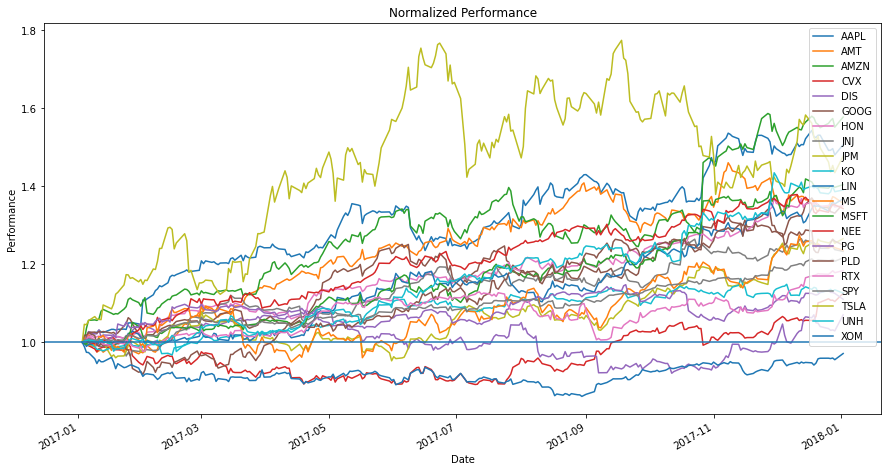

In [13]:
# Normalized cumulative return
plot_data(norm_df, 'Normalized Performance', 'Date', 'Performance')

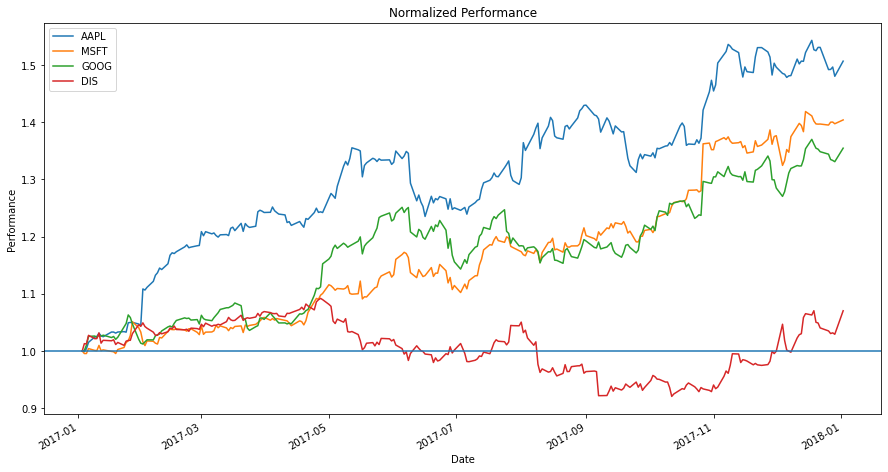

In [14]:
# Tech and Communication Companies
plot_data(norm_df[['AAPL', 'MSFT', 'GOOG','DIS']],'Normalized Performance', 'Date', 'Performance')

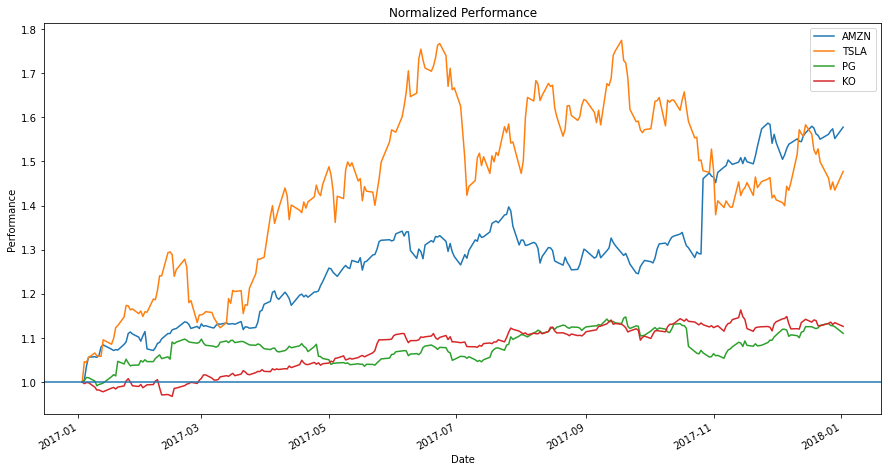

In [15]:
# Consumer Cyclical and Defensive Companies
plot_data(norm_df[['AMZN','TSLA','PG','KO']],'Normalized Performance', 'Date', 'Performance')

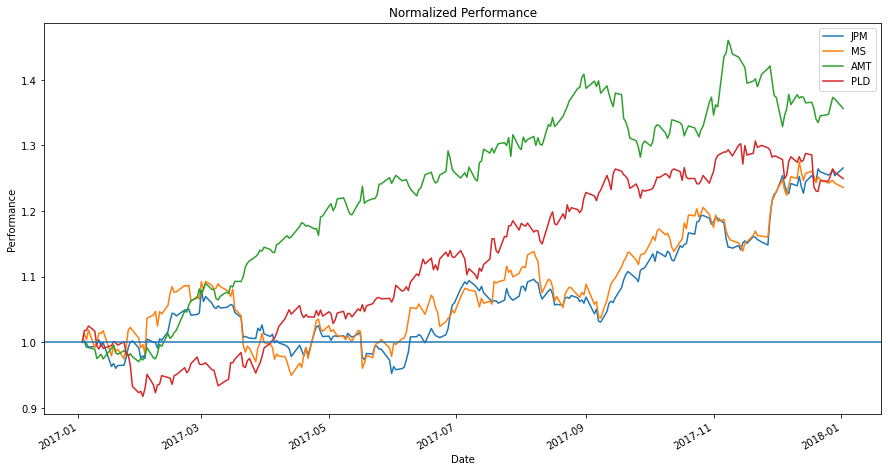

In [16]:
# Financial and Real State Companies
plot_data(norm_df[['JPM', 'MS', 'AMT','PLD']],'Normalized Performance', 'Date', 'Performance')

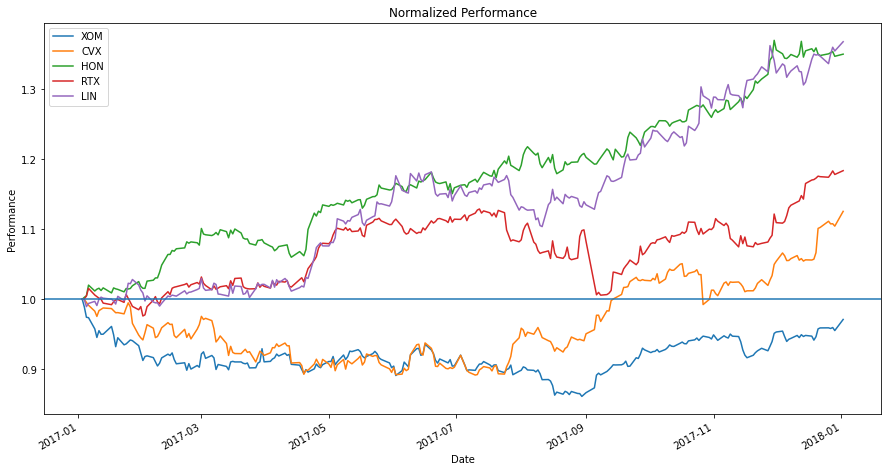

In [17]:
# Energy, Industrials and Basic Materials Companies
plot_data(norm_df[['XOM','CVX','HON','RTX', 'LIN']],'Normalized Performance', 'Date', 'Performance')

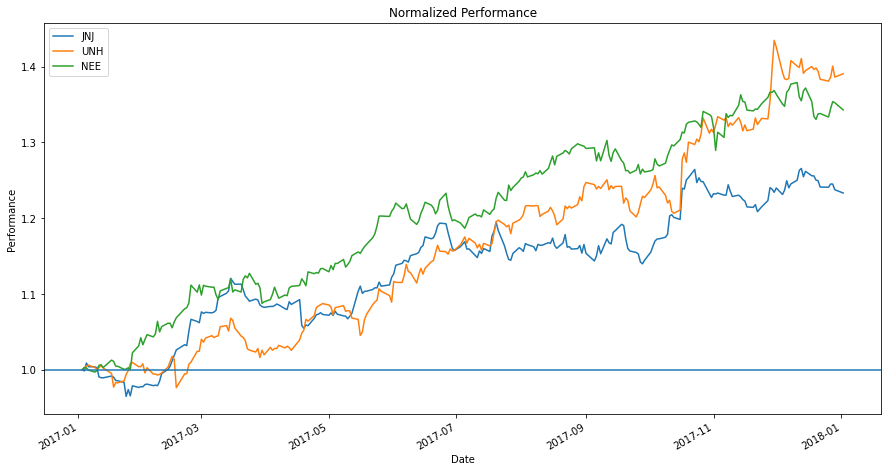

In [18]:
# Healthcare and Utilities Companies
plot_data(norm_df[['JNJ','UNH','NEE']],'Normalized Performance', 'Date', 'Performance')

# Daily Return

In [19]:
d_return = daily_return(stocks, 1)
d_return.head()

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-04,-0.001119,0.001790,0.004657,-0.000255,0.012820,0.000967,0.002754,-0.001640,0.001844,-0.003588,...,0.013240,-0.004474,0.002948,0.003563,0.017803,0.000632,0.005949,0.046085,0.002849,-0.011002
2017-01-05,0.005085,-0.003479,0.030732,-0.004329,-0.000559,0.009048,0.002232,0.010462,-0.009205,0.002401,...,-0.009170,0.000000,-0.000588,0.006627,0.000372,0.004058,-0.000794,-0.001057,0.001667,-0.014907
2017-01-06,0.011148,-0.006606,0.019912,-0.004006,0.014900,0.015277,0.015159,-0.004792,0.000116,-0.000240,...,0.014577,0.008667,-0.002941,-0.000353,0.006510,0.010777,0.003578,0.009967,0.001418,-0.000565
2017-01-09,0.009160,-0.002375,0.001168,-0.008559,-0.005689,0.000620,-0.008268,-0.000172,0.000697,-0.010062,...,-0.025998,-0.003183,-0.002528,-0.007409,-0.007577,-0.009329,-0.003301,0.009912,-0.002833,-0.016497


In [20]:
d_return.describe()

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
count,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,...,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000
mean,0.001382,0.000669,0.000908,0.000680,0.000203,0.000779,0.000623,0.000462,0.000546,0.000462,...,0.000773,0.001123,0.000885,0.000520,0.000777,0.000494,0.000519,0.002622,0.001050,0.000529
std,0.019618,0.016835,0.020958,0.020909,0.018738,0.018217,0.015991,0.012446,0.019061,0.012691,...,0.021242,0.018087,0.015853,0.012953,0.017553,0.019426,0.012444,0.038514,0.017589,0.019768
min,-0.128647,-0.151638,-0.140494,-0.221248,-0.129846,-0.111008,-0.120868,-0.100379,-0.149649,-0.096725,...,-0.156000,-0.147390,-0.134171,-0.087374,-0.172706,-0.144765,-0.109424,-0.210628,-0.172769,-0.122248
25%,-0.007433,-0.007025,-0.008536,-0.007640,-0.008149,-0.006586,-0.005844,-0.004889,-0.007953,-0.004565,...,-0.009253,-0.006577,-0.005838,-0.004864,-0.007296,-0.007109,-0.003633,-0.016371,-0.006796,-0.008823
50%,0.001097,0.001084,0.001360,0.000738,-0.000075,0.001317,0.000955,0.000393,0.000000,0.000800,...,0.000592,0.001148,0.001361,0.000736,0.001420,0.000663,0.000718,0.001663,0.001082,0.000250
75%,0.011418,0.008548,0.011066,0.009114,0.008021,0.009317,0.008002,0.006183,0.009255,0.006096,...,0.011333,0.010195,0.007657,0.006584,0.009424,0.008038,0.006100,0.019885,0.008575,0.009508
max,0.119808,0.122220,0.135359,0.227407,0.144123,0.104485,0.150684,0.079977,0.180125,0.064796,...,0.197701,0.142169,0.136904,0.120090,0.118104,0.157571,0.090603,0.198949,0.127989,0.126868


In [21]:
stds = d_return.describe().loc['std']
stds.sort_values(ascending=False)

TSLA    0.038514
MS      0.021242
AMZN    0.020958
CVX     0.020909
XOM     0.019768
AAPL    0.019618
RTX     0.019426
JPM     0.019061
DIS     0.018738
GOOG    0.018217
MSFT    0.018087
UNH     0.017589
PLD     0.017553
AMT     0.016835
LIN     0.016188
HON     0.015991
NEE     0.015853
PG      0.012953
KO      0.012691
JNJ     0.012446
SPY     0.012444
Name: std, dtype: float64

## Daily return behaviour

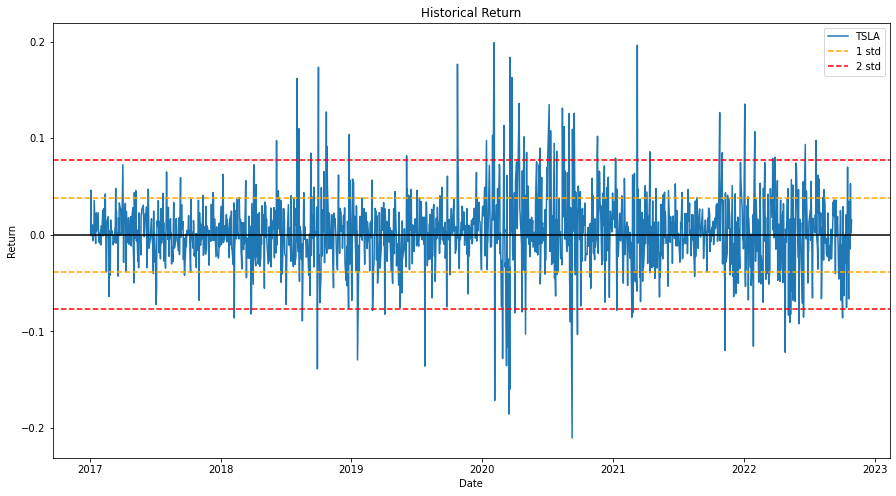

In [22]:
plot_line(d_return['TSLA'])

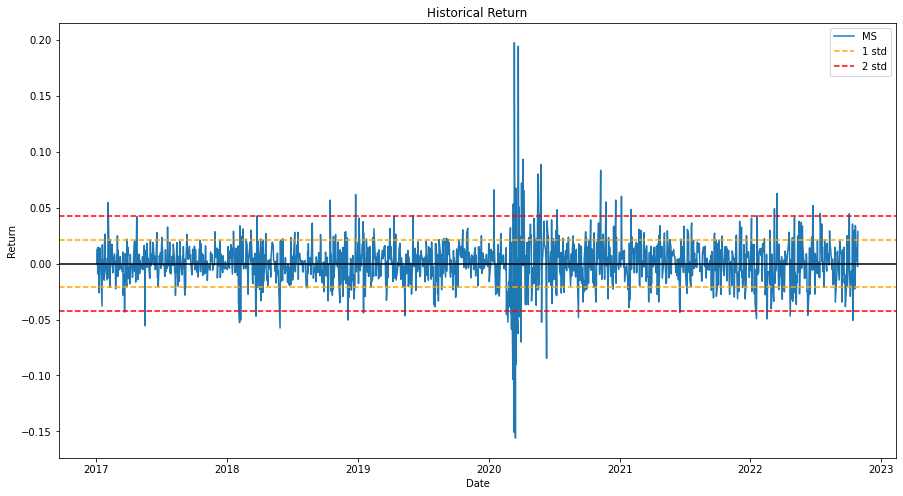

In [23]:
plot_line(d_return['MS'])

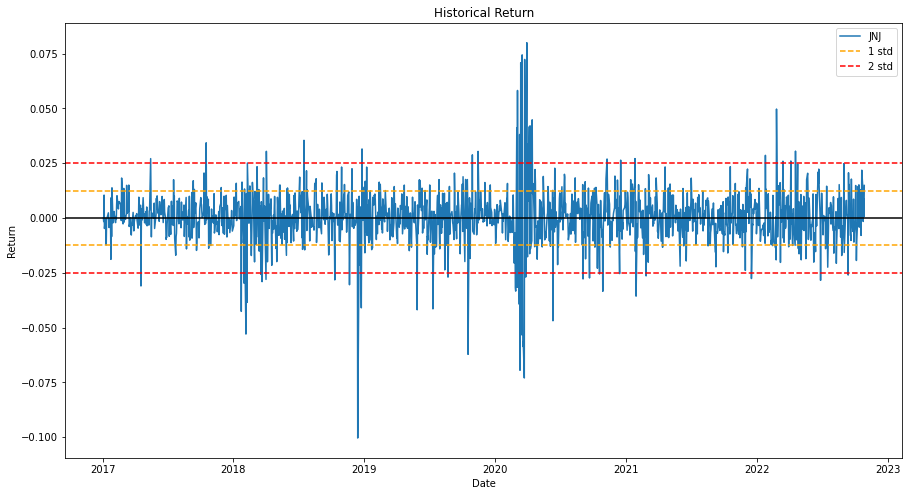

In [24]:
plot_line(d_return['JNJ'])

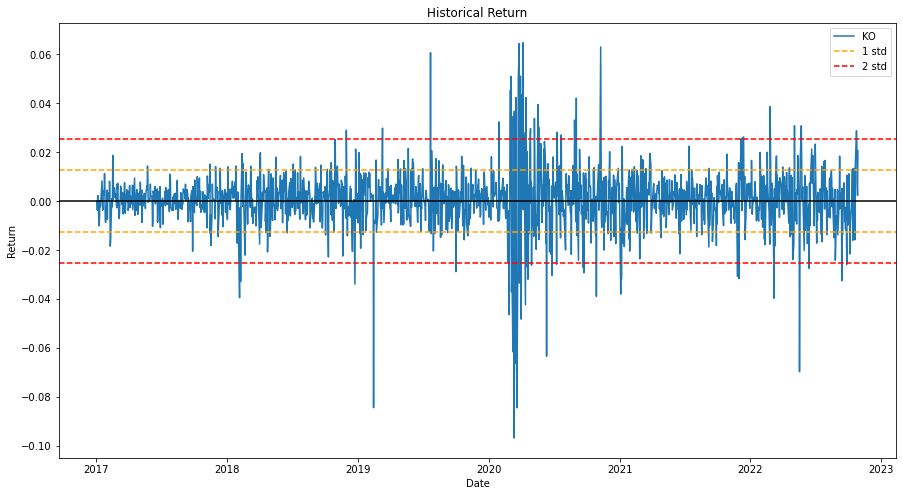

In [25]:
plot_line(d_return['KO'])

## Daily return behaviour - Histogram

The Kurtosis is: 5.341529234464108


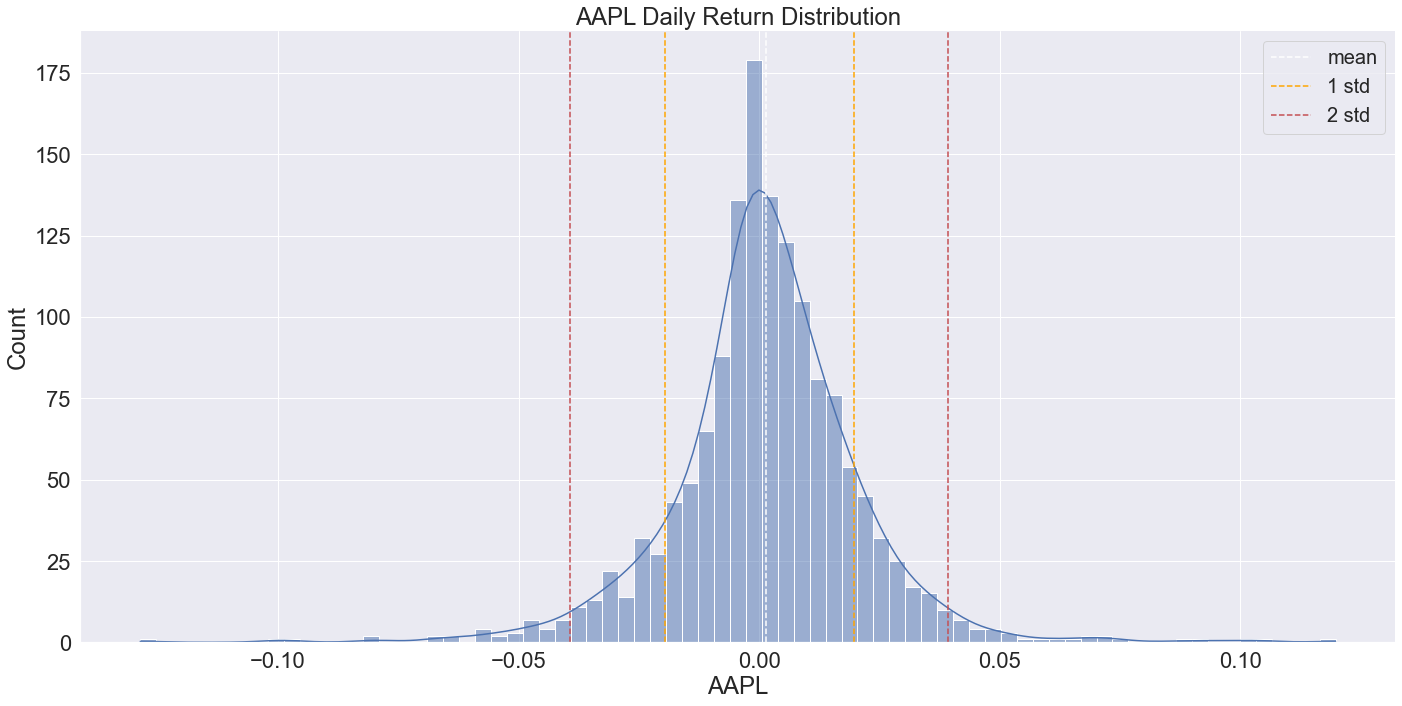

In [26]:
hist_seaborn(d_return['AAPL'])

# Scatter Plots

Beta Coeficient between SPY and JPM is 1.1410865183038308
Alpha Coeficient between SPY and JPM is -4.5422308858459844e-05


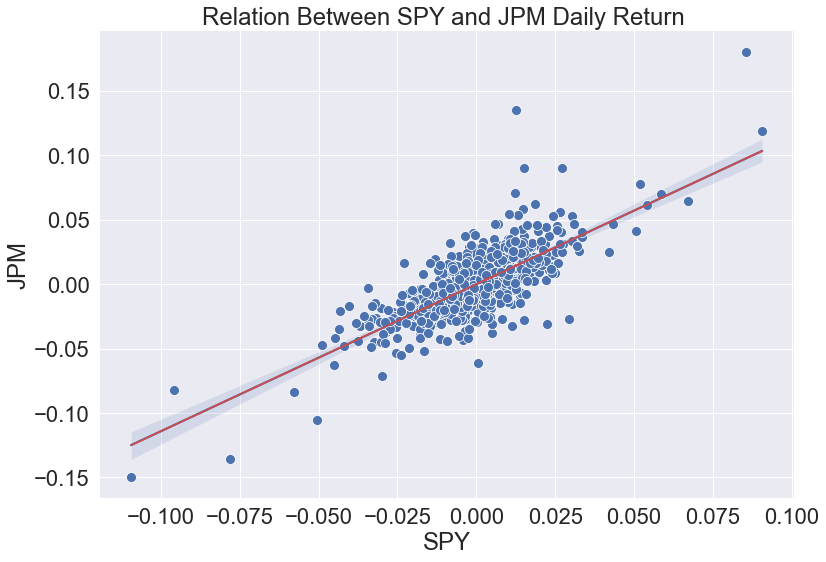

In [27]:
scatter_searborn(d_return, 'SPY', 'JPM')

Beta Coeficient between SPY and JNJ is 0.5804725416769978
Alpha Coeficient between SPY and JNJ is 0.00016059734389992173


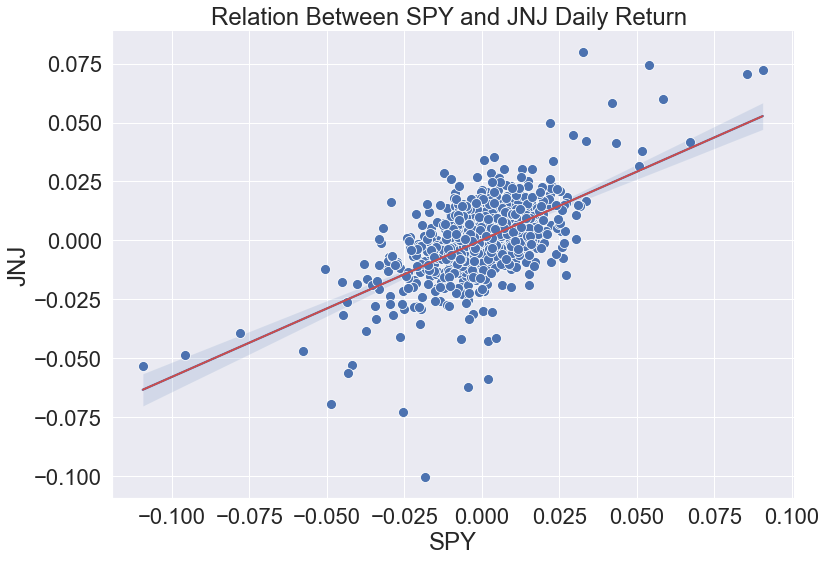

In [28]:
scatter_searborn(d_return, 'SPY', 'JNJ')

# Correlation

In [29]:
d_return_corr = d_return.corr(method='pearson')

<AxesSubplot:>

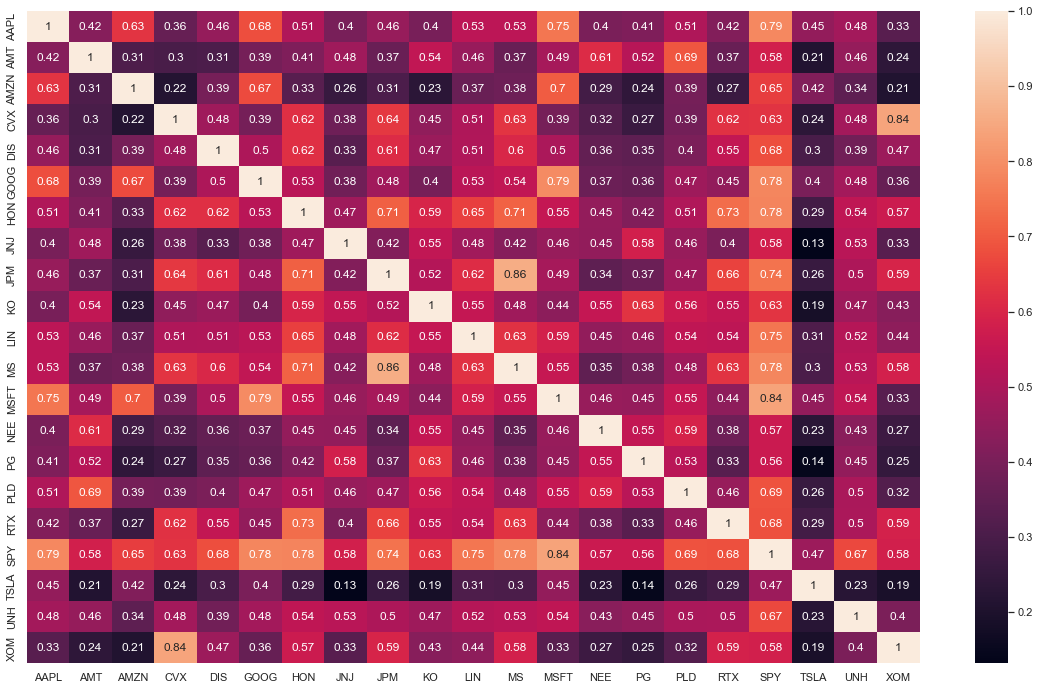

In [30]:
sns.set(rc = {'figure.figsize':(20,12)})
sns.heatmap(d_return_corr, annot=True)

# Technical Analysis

# Machine Learn

In [31]:
spy = get_data(['SPY'], '2017-01-01', '2022-10-30')
spy.drop('Close', axis=1, inplace=True)
spy.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Adj Close,Volume
Date,,,,,
2017-01-03,225.039993,225.830002,223.880005,202.856537,91366500
2017-01-04,225.619995,226.750000,225.610001,204.063354,78744400
2017-01-05,226.270004,226.580002,225.479996,203.901260,78379000
2017-01-06,226.529999,227.750000,225.899994,204.630768,71559900
2017-01-09,226.910004,227.070007,226.419998,203.955276,46939700


In [32]:
# Features
number_std = 2
df = spy['Adj Close']
features_df = pd.DataFrame({'sma5':bollinger_bands(df, 5, number_std)[0],
                           'bb5upper':bollinger_bands(df, 5, number_std)[1],
                           'bb5lower':bollinger_bands(df, 5, number_std)[2],
                           'sma30':bollinger_bands(df, 30, number_std)[0],
                           'bb30upper':bollinger_bands(df, 30, number_std)[1],
                           'bb30lower':bollinger_bands(df, 30, number_std)[2],
                           'sma60':bollinger_bands(df, 60, number_std)[0],
                           'bb60upper':bollinger_bands(df, 60, number_std)[1],
                           'bb60lower':bollinger_bands(df, 60, number_std)[2],
                           'sma200':bollinger_bands(df, 200, number_std)[0],
                           'bb200upper':bollinger_bands(df, 200, number_std)[1],
                           'bb200lower':bollinger_bands(df, 200, number_std)[2]})
features_df.head()

,sma5,bb5upper,bb5lower,sma30,bb30upper,bb30lower,sma60,bb60upper,bb60lower,sma200,bb200upper,bb200lower
Date,,,,,,,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,203.881439,205.166296,202.596583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
ml_df = spy.join(features_df)

In [34]:
# Common mistake to make is to predict data for the day using data from the same day. We really need to make sure that we are predicting tomorow prices by todays price
# 1º : Set our target - The value we want to predict. If the price will goes up or down the next day

ml_df['Target'] = ml_df['Adj Close'].shift(2)
ml_df.head(7)

,Open,High,Low,Adj Close,Volume,sma5,bb5upper,bb5lower,sma30,bb30upper,bb30lower,sma60,bb60upper,bb60lower,sma200,bb200upper,bb200lower,Target
Date,,,,,,,,,,,,,,,,,,
2017-01-03,225.039993,225.830002,223.880005,202.856537,91366500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,225.619995,226.750000,225.610001,204.063354,78744400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,226.270004,226.580002,225.479996,203.901260,78379000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202.856537
2017-01-06,226.529999,227.750000,225.899994,204.630768,71559900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.063354
2017-01-09,226.910004,227.070007,226.419998,203.955276,46939700,203.881439,205.166296,202.596583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.901260
2017-01-10,226.479996,227.449997,226.009995,203.955276,63771900,204.101187,204.704874,203.497500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.630768
2017-01-11,226.360001,227.100006,225.589996,204.531677,74650000,204.194852,204.905107,203.484596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.955276


In [35]:
ml_df.dropna(axis=0, how='any', inplace=True)
ml_df

,Open,High,Low,Adj Close,Volume,sma5,bb5upper,bb5lower,sma30,bb30upper,bb30lower,sma60,bb60upper,bb60lower,sma200,bb200upper,bb200lower,Target
Date,,,,,,,,,,,,,,,,,,
2017-10-17,255.229996,255.520004,254.979996,233.362656,31561000,233.000912,233.585916,232.415909,229.279405,234.879793,223.679017,226.428511,233.692851,219.164170,217.851529,233.201367,202.501691,232.887634
2017-10-18,255.899994,255.949997,255.500000,233.591019,40888300,233.128799,233.907418,232.350181,229.585089,235.088308,224.081870,226.573475,234.057018,219.089932,218.005201,233.366924,202.643479,233.198227
2017-10-19,254.830002,255.830002,254.350006,233.654968,61903800,233.338901,233.961361,232.716440,229.893814,235.228390,224.559237,226.719353,234.408783,219.029923,218.153159,233.545053,202.761265,233.362656
2017-10-20,256.700012,257.140015,255.770004,234.860703,89176400,233.733514,235.045420,232.421609,230.251516,235.423375,225.079657,226.888812,234.840281,218.937343,218.307957,233.746293,202.869621,233.591019
2017-10-23,257.480011,257.510010,256.019989,233.947250,63915300,233.883319,235.052951,232.713687,230.499084,235.642826,225.355342,227.047439,235.177090,218.917788,218.454539,233.927485,202.981593,233.654968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-24,375.890015,380.059998,373.109985,377.138184,85436900,369.941235,380.296951,359.585520,369.952892,391.269838,348.635946,388.914044,432.844872,344.983215,407.336555,463.040646,351.632463,363.739716
2022-10-25,378.790009,385.250000,378.670013,383.160522,78846300,372.686627,388.308624,357.064630,369.734833,390.337692,349.131974,388.513059,432.202758,344.823361,406.959111,462.287197,351.631026,372.579132
2022-10-26,381.619995,387.579987,381.350006,380.273773,104087300,375.378265,390.574246,360.182285,369.370980,388.755527,349.986433,388.108739,431.644104,344.573374,406.570088,461.546229,351.593947,377.138184


In [36]:
x = ml_df.iloc[:, :-1].values
y = ml_df.iloc[:,-1].values

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 1)

In [38]:
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression()

In [39]:
y_pred = regressor.predict(x_test)
np.set_printoptions(precision=2) # Display any numerical value with 2 decimal
compared = np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test),1)),1)
print(compared)

[[344.84 341.54]
 [312.41 308.39]
 [308.3  308.52]
 [347.19 350.59]
 [257.75 256.7 ]
 [276.96 276.67]
 [252.56 251.68]
 [256.19 256.08]
 [256.5  256.29]
 [250.05 249.76]
 [300.82 298.56]
 [322.16 315.87]
 [274.36 274.61]
 [264.88 267.32]
 [305.17 305.75]
 [295.47 295.42]
 [429.02 423.12]
 [370.79 365.81]
 [459.   459.1 ]
 [365.5  361.13]
 [286.81 287.72]
 [469.86 469.86]
 [393.39 391.76]
 [265.41 265.73]
 [405.68 401.81]
 [356.2  354.58]
 [265.41 264.63]
 [282.8  282.89]
 [272.58 276.24]
 [412.54 412.71]
 [408.02 406.56]
 [251.08 246.79]
 [407.45 407.48]
 [277.06 277.27]
 [367.96 376.24]
 [261.5  262.98]
 [252.37 253.41]
 [292.31 291.81]
 [258.16 258.68]
 [248.91 247.94]
 [441.83 441.28]
 [441.76 441.38]
 [274.31 275.25]
 [312.05 313.13]
 [268.4  269.34]
 [269.83 269.37]
 [241.84 242.2 ]
 [270.37 266.34]
 [263.54 262.79]
 [240.97 240.09]
 [437.53 442.73]
 [444.42 444.79]
 [277.11 278.54]
 [244.2  245.49]
 [261.19 261.48]
 [226.89 230.32]
 [256.44 258.53]
 [319.7  319.29]
 [272.05 272.6

In [40]:
print(y_test)

[341.54 308.39 308.52 350.59 256.7  276.67 251.68 256.08 256.29 249.76
 298.56 315.87 274.61 267.32 305.75 295.42 423.12 365.81 459.1  361.13
 287.72 469.86 391.76 265.73 401.81 354.58 264.63 282.89 276.24 412.71
 406.56 246.79 407.48 277.27 376.24 262.98 253.41 291.81 258.68 247.94
 441.28 441.38 275.25 313.13 269.34 269.37 242.2  266.34 262.79 240.09
 442.73 444.79 278.54 245.49 261.48 230.32 258.53 319.29 272.66 438.98
 269.63 307.78 459.19 400.08 431.08 248.43 252.89 295.9  379.22 299.16
 406.52 371.28 282.42 249.29 275.85 279.23 256.44 295.46 239.41 455.58
 360.72 368.81 245.61 425.7  445.21 424.36 444.62 414.32 338.59 298.85
 382.49 316.68 297.75 324.99 275.5  261.42 418.49 411.33 264.35 316.44
 410.09 433.43 377.94 430.99 302.21 262.6  457.4  396.26 234.9  254.5
 279.91 351.66 248.66 294.33 392.15 445.13 379.46 271.59 256.94 296.01
 315.75 252.54 243.83 242.42 309.85 294.65 293.23 406.47 284.32 420.59
 407.22 344.89 251.5  264.43 394.34 266.76 432.01 413.56 316.17 298.25
 344.51

In [41]:
print(y_pred)

[344.84 312.41 308.3  347.19 257.75 276.96 252.56 256.19 256.5  250.05
 300.82 322.16 274.36 264.88 305.17 295.47 429.02 370.79 459.   365.5
 286.81 469.86 393.39 265.41 405.68 356.2  265.41 282.8  272.58 412.54
 408.02 251.08 407.45 277.06 367.96 261.5  252.37 292.31 258.16 248.91
 441.83 441.76 274.31 312.05 268.4  269.83 241.84 270.37 263.54 240.97
 437.53 444.42 277.11 244.2  261.19 226.89 256.44 319.7  272.05 435.08
 270.29 307.12 453.51 398.56 429.42 248.19 252.67 295.87 377.97 298.86
 404.77 373.93 288.39 247.5  276.67 276.33 256.52 295.36 242.11 451.46
 360.77 368.38 245.64 425.15 445.84 427.73 446.06 413.81 338.82 298.52
 380.33 318.12 297.61 323.78 276.41 275.74 418.51 411.02 264.22 315.45
 410.09 439.57 377.06 435.   303.32 262.15 456.11 397.94 235.07 252.7
 279.94 351.81 247.72 295.24 391.75 447.77 382.   270.97 256.67 294.12
 317.33 251.18 244.8  244.11 310.9  286.22 293.94 409.11 284.56 415.02
 406.44 343.35 251.23 263.79 391.57 264.1  436.54 413.45 318.71 290.85
 337.86 

In [42]:
# MSE
mean_squared_error(y_test, y_pred)

6.288199066426351

In [43]:
# RMSE
mean_squared_error(y_test, y_pred, squared=False)

2.5076281754730605

In [44]:
# R squared score (R² score)
# A high r2_score reflects a good model performance on the test set.
r2_score(y_test, y_pred)

0.9987670602153369

In [45]:
# adjusted R squared scored (R²-adj score)
r2 = r2_score(y_test, y_pred)
n = len(y_test)
k = len(ml_df.iloc[:, :-1].columns)
# calculate adjusted r2 score
adj_r2_score = 1-(((1-r2)*(n-1))/(n-k-1))
adj_r2_score

0.9986782467562721

<AxesSubplot:>

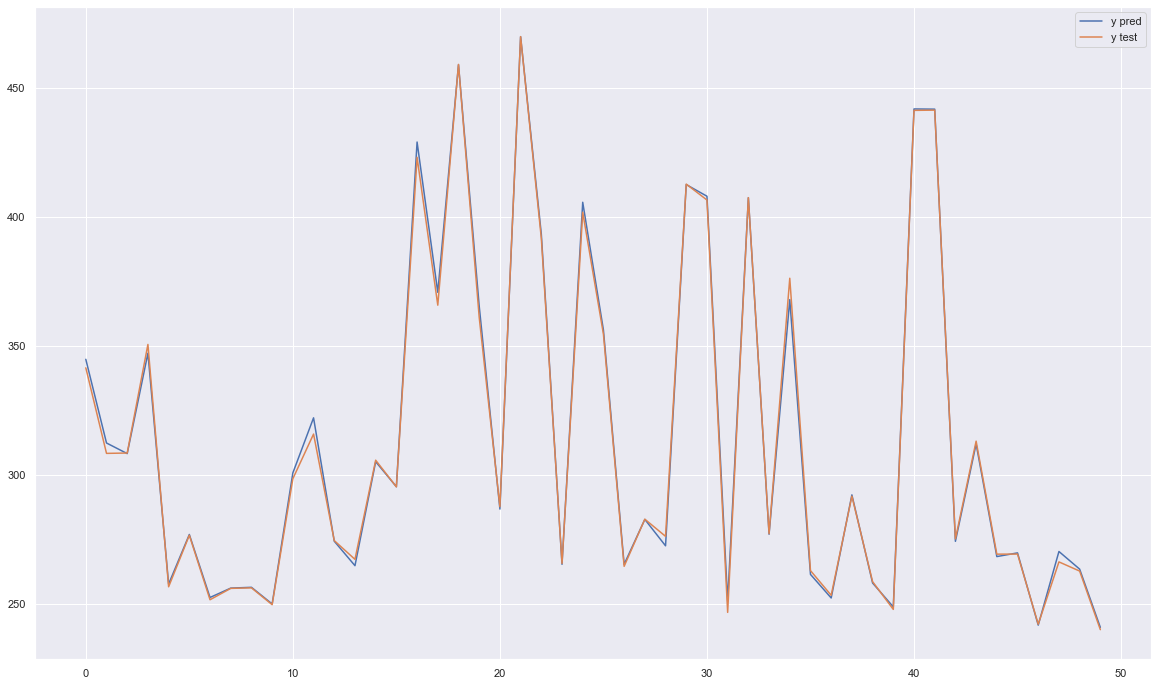

In [46]:
df = pd.DataFrame(compared, columns=['y pred', 'y test'])
df.iloc[0:50,:].plot()